In [ ]:
!pip install transformers

## Data preparation

### 1. Loading data

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path
import zipfile

source_dir = Path('/content/drive/MyDrive/Colab Notebooks/datasets/disaster_tweets.zip')
zip_ref = zipfile.ZipFile(source_dir, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
import pandas as pd

train_df = pd.read_csv('/tmp/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
import random

i = random.choice(range(0, len(train_df)))
text = train_df.iloc[i]['text']

print('Example text:')
print()
print(text)

Example text:

Senator 'alarmed' by reports U.S. military families harassed: A U.S. Senator said on Wednesday he was alarmed byÛ_ http://t.co/sbILA2Yqjq


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
print('total training samples: ', len(train_df))

total training samples:  7613


### 2. Class imbalance

Down sample majority class.

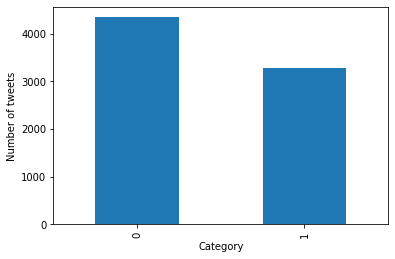

In [ ]:
import matplotlib.pyplot as plt

plt.xlabel('Category')
plt.ylabel('Number of tweets')

train_df['target'].value_counts(sort=False).plot(kind='bar')

In [ ]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
from sklearn.utils import resample

df_maj = train_df[train_df['target'] == 0]
df_min = train_df[train_df['target'] == 1]

num_samples = int(len(df_min)/2) # resource limit

df_maj = resample(df_maj,
                  replace=False,
                  n_samples=num_samples,
                  random_state=42)

df_min = resample(df_min,
                  replace=False,
                  n_samples=num_samples, 
                  random_state=42)

balanced_df = pd.concat([df_maj, df_min])

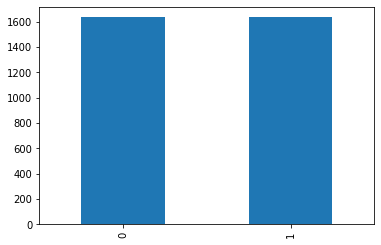

In [ ]:
balanced_df['target'].value_counts(sort=False).plot(kind='bar')

### 3. Remove columns

Columns that will be used as input: text, target

In [ ]:
balanced_df.drop(labels=['id', 'keyword', 'location'], axis=1, inplace=True)

In [ ]:
balanced_df.head()

,text,target
3697,Everyday is a near death fatality for me on th...,0
4180,#Lifestyle Û÷It makes me sickÛª: Baby clothe...,0
4634,@Lenn_Len Probably. We are inundated with them...,0
6135,A demoness with the voice of an angel. Like a ...,0
4568,Next Man Up---AH SCREW THIS! I'm so tired of i...,0


### 4. Train-test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(balanced_df['text'].values,
                                                    balanced_df['target'].values,
                                                    test_size=0.2,
                                                    random_state=42)

print('X_train: ', len(X_train))
print('X_test: ', len(X_test))

X_train:  2616
X_test:  654


### 5. Preprocess data

Tokenize and encode texts appropriate for BERT model, using the pre-trained BERT tokenizer (`bert-base-uncased`).

In [ ]:
from transformers import BertTokenizer

MODEL_TYPE = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE)

In [ ]:
def convert_to_dict(input_ids, token_type_ids, attention_mask, label):
    return {
        'input_ids': input_ids,
        'token_type_ids': token_type_ids,
        'attention_mask': attention_mask
    }, label

In [ ]:
import tensorflow as tf

def encode_texts(X, y):
    MAX_LEN = 512 # max length of a medical note
    BATCH_SIZE = 6

    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []

    for texts, label in zip(X, y):
        encoded = tokenizer.encode_plus(
            texts,
            add_special_tokens=True,
            max_length = MAX_LEN,
            pad_to_max_length = True,
            return_attention_mask = True
        )

        input_ids_list.append(encoded['input_ids'])
        token_type_ids_list.append(encoded['token_type_ids'])
        attention_mask_list.append(encoded['attention_mask'])
        label_list.append([label])

    dataset = tf.data.Dataset.from_tensor_slices((input_ids_list, 
                                                  token_type_ids_list, 
                                                  attention_mask_list, 
                                                  label_list))
    dataset = dataset.map(convert_to_dict)
    dataset = dataset.shuffle(len(X_train))
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)

    return dataset

In [ ]:
train_ds = encode_texts(X_train, y_train)
valid_ds = encode_texts(X_test, y_test)

## Training and evaluation

In [ ]:
from tensorflow.keras.optimizers import Adam
from transformers import TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained(MODEL_TYPE)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(2e-5),
              metrics=['accuracy'])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
history = model.fit(train_ds, 
                    epochs=5, 
                    validation_data=valid_ds,
                    verbose=1)

Epoch 1/5
436/436 [==============================] - 656s 1s/step - loss: 1.0144 - accuracy: 0.5292 - val_loss: 0.6931 - val_accuracy: 0.5826
Epoch 2/5
436/436 [==============================] - 635s 1s/step - loss: 0.6931 - accuracy: 0.5349 - val_loss: 0.6931 - val_accuracy: 0.5826
Epoch 3/5
436/436 [==============================] - 634s 1s/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.6931 - val_accuracy: 0.5826
Epoch 4/5
436/436 [==============================] - 634s 1s/step - loss: 0.6931 - accuracy: 0.5098 - val_loss: 0.6931 - val_accuracy: 0.5826
Epoch 5/5
436/436 [==============================] - 634s 1s/step - loss: 0.6931 - accuracy: 0.5379 - val_loss: 0.6931 - val_accuracy: 0.5826
